In [1]:
import json
import pandas as pd
import requests
import twitter

In [2]:
import time

In [3]:
import matplotlib.pyplot as plt
import wordcloud

In [4]:
import itertools

In [5]:

# reading the data from the file 
with open('twitter_dict.txt') as f: 
    data = f.read() 
    authentification = json.loads(data) 

In [6]:
api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')

In [7]:
banks = {"Česká spořitelna":"ceskasporitelna",
         "Československá obchodní banka":"csob_cz",
         "Komerční Banka":"komercka",
         "UniCredit":"unicredit_czsk",
         "Raiffeisenbank":"raiffeisencz"}

In [8]:
class Comparison_collection():
    '''
    Class containing methods for comparing among different twitter users posts and their mentions posts. 
    '''
    
    def __init__(self,dictionary, authentification):
        '''
        Loads a dictionary with {"full_name":"twitter_handle"} pairs and saves this logic
        also creates an python-twitter API object based on a dictionary with API keys,
        consumer key and secret must be called API_key and API_secret_key respectively,
        access token key and access token secret must be called Access_token and Access_token_secret respectively
        '''

        self.users = dictionary
        
    
        self.api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')
    
    def create_user_data(self):
        
        for name in self.users:
            
            self.accounts = {name: Twitter_user(self.users[name], self.api) for name in self.users}
            
    def get_users_tweets(self):
        
        for name in self.users:
            
            self.accounts[name].gather_tweets()
    

In [12]:
cz_banks = Comparison_collection(banks, authentification)

In [397]:
class Twitter_user():
    '''
    Class containing timeline (list of all recent tweets), mentions (all tweets where they were tagged), statistics about the posts and users themselves.
    Methods are used to extract all neccesary data and output it as csv file.
    note that a maximum of 3200 posts retrieved per API endpoint - We expect around 3200 timeline tweets and 3200 mentions maximum per account.
    twitter handle (username) is required to construct the user, as is an authentification dictionary with API keys (provided for you in this example)
    
    '''
    
    def __init__(self, twitter_handle, api):

        self.reply_pd =[]
        self.timeline_tweet_pd=[]
        self.twitter_handle = twitter_handle
        self.interesting_user_atributes = ['screen_name', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'location']
        self.interesting_tweet_attributes = ['full_text', 'lang', 'retweet_count','created_at', 'source']
        self.api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')
        
    # First of all, get as much tweets as possible through each endpoint.
    # we iterate over tweets, always checking if the call returned additional tweets.
    def get_timeline(self):
        timeline = self.api.GetUserTimeline(screen_name=self.twitter_handle, count=200)
        earliest_tweet = min(timeline, key=lambda x: x.id).id
        print("getting tweets before:", earliest_tweet)

        while True:
            tweets = self.api.GetUserTimeline(
                screen_name=self.twitter_handle, max_id=earliest_tweet, count=200
            )
            new_earliest = min(tweets, key=lambda x: x.id).id

            if not tweets or new_earliest == earliest_tweet:
                break
            else:
                earliest_tweet = new_earliest
                print("getting tweets before:", earliest_tweet)
                timeline += tweets

        self.timeline = timeline

    def get_mentions(self):
        mentions = self.api.GetSearch(term=self.twitter_handle ,include_entities=True, count=200, result_type='recent')
        earliest_tweet_mentions = min(mentions, key=lambda x: x.id).id
        print("getting mentions before:", earliest_tweet_mentions)

        while True:
            mentions_add = self.api.GetSearch(
                term=self.twitter_handle, max_id=earliest_tweet_mentions, include_entities=True, count=200, result_type='recent'
            )
            new_earliest = min(mentions_add, key=lambda x: x.id).id

            if not mentions_add or new_earliest == earliest_tweet_mentions:
                break
            else:
                earliest_tweet_mentions = new_earliest
                print("getting mentions before:", earliest_tweet_mentions)
                mentions += mentions_add
        self.mentions = mentions

# define a method that calls both methods to gather all tweets relevant to the account
    def gather_relevant_tweets(self):
        self.get_mentions()
        self.get_timeline()

        
# extract profile details for the username from arbitrarily chosen tweet
    def get_account_details(self):
        '''
        requires at least one tweet in the timeline attribute Call get_timeline() or gather_tweets() to construct it
        '''
        self.details = {}
        self.detail_atributes_required = ('favourites_count', 'followers_count', 'friends_count', 'statuses_count')
        self.details = {k: self.timeline[1]._json['user'][k] for k in self.interesting_user_atributes}
        print(self.details)
        
        
        
        
    def extract_mention_user_data(self):
        for mention in self.mentions:
            mention.user_info = {k: mention._json['user'][k] for k in self.interesting_user_atributes}
        
    def extract_mention_tweet_data(self):    
        for mention in self.mentions:
            mention.tweet_info = {k: mention._json[k] for k in self.interesting_tweet_attributes}
        
## Now extract timeline information for the user. If the timeline tweet is a reply to another tweet, also gather those tweets and gather information from them
    def generate_mentions_pdf(self):
        self.mentions_pd_list = []
        for num, tweet in enumerate(self.mentions, start=0):
            self.mentions_pd_list.append(pd.DataFrame( {**self.mentions[num].user_info, **self.mentions[num].tweet_info},
                                                           index =  [self.mentions[num].user_info['screen_name']])
                                   )
            
        self.mentions_pd = pd.concat(self.mentions_pd_list)
        
    def extract_timeline_tweet_data(self):
        for tl_tweet in self.timeline:
            tl_tweet.tweet_info ={k: tl_tweet._json[k] for k in self.interesting_tweet_attributes}
        
        
    def get_replied_to_tweet(self):
        self.rate_limiter_getstatus_ts = datetime.datetime.now()
        self.rate_limiter_getstatus_counter = 0
        ## using enumeration to have an easy way to handle api rate limiting
        for timeline_tweet in self.timeline:
            if (self.rate_limiter_getstatus_counter+1)%899 == 0:
                time_to_wait = max(0, (15*60) - max(0,(datetime.datetime.now() - self.rate_limiter_getstatus_ts).total_seconds()))
                print(f"sleeping at {datetime.datetime.now()} for {time_to_wait} seconds")
                time.sleep(time_to_wait)
            if timeline_tweet.in_reply_to_status_id is None:
                timeline_tweet.reply_tweet = None
            else:
                self.rate_limiter_getstatus_counter +=1
                try:
                    timeline_tweet.reply_tweet = self.api.GetStatus(timeline_tweet.in_reply_to_status_id)

                except (twitter.TwitterError, TypeError, ValueError): 
                    timeline_tweet.reply_tweet = None
                else:
                    pass

    def retry_replied_to_tweet(self):
    ## not only rate limiting, but other unexpected problems might arise. If we have status id of the tweet the account is replying to, but no associated tweet, retry to get the tweet
        for timeline_tweet in self.timeline:
            if (self.rate_limiter_getstatus_counter+1)%899 == 0:
                time_to_wait = max(0, (15*60) - max(0,(datetime.datetime.now() - self.rate_limiter_getstatus_ts).total_seconds()))
                print(f"sleeping at {datetime.datetime.now()} for {time_to_wait} seconds")
                time.sleep(time_to_wait)
                self.rate_limiter_getstatus_ts = datetime.datetime.now()

            if timeline_tweet.in_reply_to_status_id is None:
                pass
            else:
                if timeline_tweet.reply_tweet is None:
                    self.rate_limiter_getstatus_counter +=1
                    try:
                        timeline_tweet.reply_tweet = self.api.GetStatus(timeline_tweet.in_reply_to_status_id)

                    except (twitter.TwitterError, TypeError, ValueError): 
                        timeline_tweet.reply_tweet = None
                else:
                    pass


                
                
    def extract_reply_tweet_info(self):
        self.reply_atributes_required = ( 'created_at', 'full_text', 'retweet_count', 'favorite_count')
        self.reply_user_required = ('screen_name', 'followers_count', 'friends_count', 'statuses_count', "favourites_count")
        for num in list(range(0, len(self.timeline))):


            try:
                self.timeline[num].reply_tweet_info = {k: self.timeline[num].reply_tweet._json[k] for k in self.reply_atributes_required}
            except:
                self.timeline[num].reply_tweet_info = {k: None for k in self.reply_atributes_required}

            try:
                self.timeline[num].user_info = {k: self.timeline[num].reply_tweet._json['user'][k] for k in self.reply_user_required}
            except: 
                self.timeline[num].user_info = {k: None for k in self.reply_user_required}

    def generate_timeline_pdf(self):
        self.reply_pd = []
        for num in list(range(0, len(self.timeline))):
                self.timeline[num].reply_info = {**self.timeline[num].user_info, **self.timeline[num].reply_tweet_info}

                self.timeline[num].reply_info = add_prefix_to_dict(self.timeline[num].reply_info, "reply_")

                self.timeline[num].concat_info = {**self.timeline[num].tweet_info, **self.timeline[num].reply_info}
                self.reply_pd.append(pd.DataFrame(self.timeline[num].concat_info,
                                                       index =  [num])
                                )
        self.timeline_pd = pd.concat(self.reply_pd)    
        
    def do_all(self):
        self.gather_relevant_tweets()
        self.get_account_details()
        self.extract_mention_user_data()
        self.extract_mention_tweet_data()
        self.extract_timeline_tweet_data()
        self.get_replied_to_tweet()
        self.retry_replied_to_tweet()
        self.extract_reply_tweet_info()
        self.generate_timeline_pdf()
        self.generate_mentions_pdf()

In [207]:
def retry_replied_to_tweet(self):
## not only rate limiting, but other unexpected problems might arise. If we have status id of the tweet the account is replying to, but no associated tweet, retry to get the tweet
    for timeline_tweet in self.timeline:
        if (self.rate_limiter_getstatus_counter+1)%899 == 0:
            time_to_wait =  max(0, (15*60) - (datetime.datetime.now() - self.rate_limiter_getstatus_ts).total_seconds())
            print(f"sleeping at {datetime.datetime.now()} for {time_to_wait} seconds")
            time.sleep(time_to_wait)
            self.rate_limiter_getstatus_ts = datetime.datetime.now()

        if timeline_tweet.in_reply_to_status_id is None:
            pass
        else:
            if timeline_tweet.reply_tweet is None:
                self.rate_limiter_getstatus_counter +=1
                try:
                    timeline_tweet.reply_tweet = self.api.GetStatus(timeline_tweet.in_reply_to_status_id)

                except (twitter.TwitterError, TypeError, ValueError): 
                    timeline_tweet.reply_tweet = None
            else:
                pass



In [208]:
rajf.rate_limiter_getstatus_counter

1797

In [202]:
retry_replied_to_tweet(rajf)

sleeping at 2021-02-16 13:49:20.558638 for 0 seconds
sleeping at 2021-02-16 13:49:20.558638 for 900.0 seconds
sleeping at 2021-02-16 14:04:20.559391 for 900.0 seconds
sleeping at 2021-02-16 14:19:20.559443 for 900.0 seconds
sleeping at 2021-02-16 14:34:20.561500 for 900.0 seconds


KeyboardInterrupt: 

In [203]:
(datetime.datetime.now() - rajf.rate_limiter_getstatus_ts).total_seconds()

903.431953

In [204]:
(rajf.rate_limiter_getstatus_ts - datetime.datetime.now()).total_seconds()

-904.077386

In [198]:
rajf = Twitter_user('raiffeisencz', authentification)

In [199]:
rajf.do_all()

getting mentions before: 1358797995492450305
getting tweets before: 1326079306196541442
getting tweets before: 1286273731481010176
getting tweets before: 1245421306549604353
getting tweets before: 1189214023159603201
getting tweets before: 1142033813595406336
getting tweets before: 1097760996498829313
getting tweets before: 1070540257052028928
getting tweets before: 1027854579499716608
getting tweets before: 976051990441660417
getting tweets before: 932974536714280960
getting tweets before: 895930288248934401
getting tweets before: 850343680082935810
getting tweets before: 811957001236389889
getting tweets before: 770303753404710912
getting tweets before: 725646841023483904
getting tweets before: 650966461830299648
getting tweets before: 628551290117857281
{'screen_name': 'RaiffeisenCZ', 'favourites_count': 253, 'followers_count': 2677, 'friends_count': 298, 'statuses_count': 3706, 'location': 'Czech Republic'}
sleeping at 2021-02-16 13:30:40.068524 for 741.052266 seconds
sleeping at 2

ValueError: sleep length must be non-negative

In [196]:
retry_replied_to_tweet(rajf)

AttributeError: 'Status' object has no attribute 'reply_tweet'

In [105]:
time.sleep(5)

In [195]:
def retry_replied_to_tweet(self):
## not only rate limiting, but other unexpected problems might arise. If we have status id of the tweet the account is replying to, but no associated tweet, retry to get the tweet
    for num in list(range(0, len(self.timeline))):
        if (self.rate_limiter_getstatus_counter+1)%899 == 0:
            time_to_wait =  (15*60) - (datetime.datetime.now() - self.rate_limiter_getstatus_ts).total_seconds()
            print(f"sleeping at {datetime.datetime.now()} for {time_to_wait} seconds")
            time.sleep(time_to_wait)
            self.rate_limiter_getstatus_ts = datetime.datetime.now()

        if self.timeline[num].in_reply_to_status_id is None:
            pass
        else:
            if self.timeline[num].reply_tweet is None:
                self.rate_limiter_getstatus_counter +=1
                try:
                    self.timeline[num].reply_tweet = self.api.GetStatus(self.timeline[num].in_reply_to_status_id)

                except (twitter.TwitterError, TypeError, ValueError): 
                    self.timeline[num].reply_tweet = None
            else:
                pass

In [129]:
sporka.rate_limiter_getstatus_ts

datetime.datetime(2021, 2, 16, 11, 34, 54, 958556)

In [128]:
sporka.rate_limiter_getstatus_counter

898

In [126]:
print(f"sleeping at {datetime.datetime.now()}")

sleeping at 2021-02-16 11:34:54.965536


In [189]:
                    
def retry_replied_to_tweet(self):
## not only rate limiting, but other unexpected problems might arise. If we have status id of the tweet the account is replying to, but no associated tweet, retry to get the tweet
    for num in list(range(0, len(self.timeline))):
        if (self.rate_limiter_getstatus_counter+1)%899 == 0:
            time_to_wait =  (datetime.datetime.now() - self.rate_limiter_getstatus_ts).total_seconds()
            print(f"sleeping at {datetime.datetime.now()}")
            time.sleep(time_to_wait)
            self.rate_limiter_getstatus_ts = datetime.datetime.now()
            
        if self.timeline[num].in_reply_to_status_id is None:
            pass
        else:
            if self.timeline[num].reply_tweet is None:
                self.rate_limiter_getstatus_counter +=1
                try:
                    self.timeline[num].reply_tweet = self.api.GetStatus(self.timeline[num].in_reply_to_status_id)

                except twitter.TwitterError: 
                    self.timeline[num].reply_tweet = None
            else:
                pass



In [133]:
time_to_wait

NameError: name 'time_to_wait' is not defined

In [ ]:
def extract_replied_to_tweet_info(self):
    for num in list(range(0, len(self.timeline))):
        try:
            tweet_info = {k: getattr(self.timeline[num].reply_tweet, k) for k in self.reply_atributes_required}
        except:
            tweet_info = {k: None for k in self.reply_atributes_required}

        try:
            user_info = {k: None for k in self.reply_user_required}
        except: 
            user_info = {k: getattr(self.timeline[num].reply_tweet.user, k) for k in self.reply_user_required}
        self.timeline[num].reply_info = {**user_info, **tweet_info}


In [143]:
retry_replied_to_tweet(sporka)

In [190]:
retry_replied_to_tweet(rajf)

AttributeError: 'Status' object has no attribute 'reply_tweet'

In [144]:

for num, tweet in enumerate(sporka.timeline, start=0):

    print(num, type(sporka.timeline[num].reply_tweet))
        #user_info = {k: getattr(sporka.timeline[num].reply_tweet, k) for k in sporka.reply_tweet_required}
        #tweet_info = {k: getattr(sporka.timeline[num].reply_tweet, k) for k in sporka.reply_atributes_required}
        #sporka.timeline[num].reply_info = {**user_info, **tweet_info}


0 <class 'NoneType'>
1 <class 'twitter.models.Status'>
2 <class 'twitter.models.Status'>
3 <class 'twitter.models.Status'>
4 <class 'twitter.models.Status'>
5 <class 'twitter.models.Status'>
6 <class 'NoneType'>
7 <class 'twitter.models.Status'>
8 <class 'twitter.models.Status'>
9 <class 'twitter.models.Status'>
10 <class 'twitter.models.Status'>
11 <class 'twitter.models.Status'>
12 <class 'twitter.models.Status'>
13 <class 'twitter.models.Status'>
14 <class 'twitter.models.Status'>
15 <class 'twitter.models.Status'>
16 <class 'twitter.models.Status'>
17 <class 'twitter.models.Status'>
18 <class 'NoneType'>
19 <class 'twitter.models.Status'>
20 <class 'twitter.models.Status'>
21 <class 'twitter.models.Status'>
22 <class 'twitter.models.Status'>
23 <class 'twitter.models.Status'>
24 <class 'twitter.models.Status'>
25 <class 'twitter.models.Status'>
26 <class 'twitter.models.Status'>
27 <class 'twitter.models.Status'>
28 <class 'twitter.models.Status'>
29 <class 'twitter.models.Status'>

In [111]:
get_replied_to_tweet(sporka)

In [80]:
rate_limiter_getstatus_counter

3

In [48]:
import datetime

In [67]:
rate_limiter_getstatus_ts1 = datetime.datetime.now()

In [68]:
rate_limiter_getstatus_ts2 = datetime.datetime.now()

In [60]:
rate_limiter_getstatus_ts1

datetime.datetime(2021, 2, 16, 10, 36, 15, 720883)

In [61]:
rate_limiter_getstatus_ts2

datetime.datetime(2021, 2, 16, 10, 36, 19, 495513)

In [72]:
(rate_limiter_getstatus_ts2 - rate_limiter_getstatus_ts1).total_seconds()

2.773495

In [30]:
def extract_mention_user_data(self):

    self.interesting_atributes = ['screen_name', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'location']
    for mention in self.mentions:
        mention.user_info = (
            {k: mention._json['user'][k] for k in self.interesting_atributes}
        )

In [37]:
def extract_mention_tweet_data(self):    

    tweet_attributes = ['full_text', 'lang', 'retweet_count','created_at', 'source']

    for mention in self.mentions:
        mention.tweet_info = (
           {k: mention._json[k] for k in tweet_attributes}
        )
            

In [38]:
extract_mention_tweet_data(sporka)

In [40]:
sporka.mentions[1].tweet_info

{'full_text': '@Ceskasporitelna Už druhý den marně, nefunguje George proč ?Už je to dlouho',
 'lang': 'cs',
 'retweet_count': 0,
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'}

In [25]:
sporka =  Twitter_user('ceskasporitelna', authentification)

In [26]:
sporka.gather_relevant_tweets()

getting mentions before: 1360233348430446594
getting mentions before: 1358813403641499649
getting tweets before: 1346449631807377409
getting tweets before: 1317203967684890624
getting tweets before: 1288483699173003269
getting tweets before: 1259833571725807620
getting tweets before: 1238840936081178624
getting tweets before: 1213583566078038017
getting tweets before: 1184739070553083904
getting tweets before: 1166689917948321792
getting tweets before: 1141966577216212992
getting tweets before: 1117830176698580997
getting tweets before: 1102900930658295808
getting tweets before: 1091275747614851073
getting tweets before: 1070648841379241984
getting tweets before: 1058667896245633027
getting tweets before: 1039874247357689857
getting tweets before: 1007305832772468736
getting tweets before: 1001031512051957760


In [31]:
extract_mention_user_data(sporka)

In [35]:
sporka.mentions[1].user_info

{'screen_name': 'IvanaPOSPILOV2',
 'favourites_count': 0,
 'followers_count': 0,
 'friends_count': 2,
 'statuses_count': 2,
 'location': ''}

In [104]:
sporka.my_reply_pd.drop_duplicates()

,screen_name,followers_count,friends_count,statuses_count,favourites_count,created_at,full_text,retweet_count,favorite_count
Ceskasporitelna,None,None,None,None,None,Mon Feb 15 15:19:23 +0000 2021,"@Ceskasporitelna @ModryVrab Bohužel, stále nef...",0,0
Ceskasporitelna,None,None,None,None,None,None,None,None,None
Ceskasporitelna,None,None,None,None,None,Mon Feb 15 12:19:36 +0000 2021,@Ceskasporitelna A proc pisete ze je to pretiz...,0,0
Ceskasporitelna,None,None,None,None,None,Mon Feb 15 11:41:36 +0000 2021,"Takový to, když umožníte transparentní účet a ...",0,3
Ceskasporitelna,None,None,None,None,None,Mon Feb 15 11:07:50 +0000 2021,@Ceskasporitelna Jak dlouho již trvá výpadek? ...,0,1
...,...,...,...,...,...,...,...,...,...
Ceskasporitelna,None,None,None,None,None,Fri Jun 01 10:03:49 +0000 2018,Kamarád mi poslal z @Ceskasporitelna peníze př...,0,6
Ceskasporitelna,None,None,None,None,None,Wed May 30 20:14:00 +0000 2018,"@Ceskasporitelna Dobrý večer, je možné, že Geo...",0,0
Ceskasporitelna,None,None,None,None,None,Tue May 29 10:05:33 +0000 2018,"Zdravim @Ceskasporitelna , můžete mi poradit, ...",0,0
Ceskasporitelna,None,None,None,None,None,Mon May 28 09:25:57 +0000 2018,#bezpecnyinternet.cz - supr věc. Tip: vytiskně...,0,0


In [97]:
sporka.extract_timeline_tweet_data()

In [98]:
sporka.generate_timeline_pdf()

In [95]:
sporka.generate_conversation_pdf()

In [102]:
sporka.my_pd.drop_duplicates()

,full_text,lang,retweet_count,source,favourites_count,followers_count,friends_count,statuses_count
Ceskasporitelna,"@Vargstjern DD, mrzí nás tyto komplikace. Bank...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"""Best in Covid? Podle počtu nadměrných úmrtí u...",cs,2,"<a href=""https://ads-api.twitter.com"" rel=""nof...",2481,4586,1400,6106
Ceskasporitelna,"@ModryVrab Dobrý den, kvůli stabilizaci aplika...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"@gugatr0n1c Dobrý den, Lubomíre, majitelku účt...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"@_thunderball1 Dobrý den, Adame, George v mobi...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
...,...,...,...,...,...,...,...,...
Ceskasporitelna,"@sbambula Dobrý den, Stando, e-faktury budou d...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,Přemýšlíte o hypotéce? Do 10. 6. 2018 můžete s...,cs,0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2481,4586,1400,6106
Ceskasporitelna,"@janjohanovsky Dobrý den, stav, který popisuje...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"@matesd @Microsoft_CZ @seznam_cz Dobrý den, Ma...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106


In [100]:
sporka.mentions_pd

,screen_name,favourites_count,followers_count,friends_count,statuses_count,location,full_text,lang,retweet_count,source
Ceskasporitelna,Ceskasporitelna,2481,4586,1400,6106,Česká republika,"@Vargstjern DD, mrzí nás tyto komplikace. Bank...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no..."
pavpouk,pavpouk,559,23,50,274,Ostrava,@podnikatel @Ceskasporitelna Asi jim zamrzly C...,cs,0,"<a href=""http://twitter.com/download/android"" ..."
Vargstjern,Vargstjern,4510,44,72,2168,Czech Republic,"@Ceskasporitelna @ModryVrab Bohužel, stále nef...",cs,0,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
Ceskasporitelna,Ceskasporitelna,2481,4586,1400,6106,Česká republika,"""Best in Covid? Podle počtu nadměrných úmrtí u...",cs,2,"<a href=""https://ads-api.twitter.com"" rel=""nof..."
podnikatel,podnikatel,133,5717,48,14105,Praha 6,Internetové bankovnictví @Ceskasporitelna dnes...,cs,0,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
...,...,...,...,...,...,...,...,...,...,...
Ceskasporitelna,Ceskasporitelna,2481,4586,1400,6106,Česká republika,"@sbambula Dobrý den, Stando, e-faktury budou d...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no..."
Ceskasporitelna,Ceskasporitelna,2481,4586,1400,6106,Česká republika,Přemýšlíte o hypotéce? Do 10. 6. 2018 můžete s...,cs,0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw..."
Ceskasporitelna,Ceskasporitelna,2481,4586,1400,6106,Česká republika,"@janjohanovsky Dobrý den, stav, který popisuje...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no..."
Ceskasporitelna,Ceskasporitelna,2481,4586,1400,6106,Česká republika,"@matesd @Microsoft_CZ @seznam_cz Dobrý den, Ma...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no..."


In [91]:
len(sporka.timeline)

3243

In [76]:
sporka.generate_timeline_pdf()

In [75]:
sporka.generate_mentions_pdf()

In [83]:
len(sporka.my_reply_pd_list)

3243

In [84]:
len(sporka.timeline_tweet_pd)

6486

In [79]:
sporka.my_pd

,full_text,lang,retweet_count,source,favourites_count,followers_count,friends_count,statuses_count
Ceskasporitelna,"@Vargstjern DD, mrzí nás tyto komplikace. Bank...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"""Best in Covid? Podle počtu nadměrných úmrtí u...",cs,2,"<a href=""https://ads-api.twitter.com"" rel=""nof...",2481,4586,1400,6106
Ceskasporitelna,"@ModryVrab Dobrý den, kvůli stabilizaci aplika...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"@gugatr0n1c Dobrý den, Lubomíre, majitelku účt...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"@_thunderball1 Dobrý den, Adame, George v mobi...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
...,...,...,...,...,...,...,...,...
Ceskasporitelna,"@sbambula Dobrý den, Stando, e-faktury budou d...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,Přemýšlíte o hypotéce? Do 10. 6. 2018 můžete s...,cs,0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2481,4586,1400,6106
Ceskasporitelna,"@janjohanovsky Dobrý den, stav, který popisuje...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106
Ceskasporitelna,"@matesd @Microsoft_CZ @seznam_cz Dobrý den, Ma...",cs,0,"<a href=""http://www.socialbakers.com/"" rel=""no...",2481,4586,1400,6106


In [78]:
sporka.generate_conversation_pdf()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
        sporka.extract_replied_to_tweet_info()
        self.generate_reply_pdf()
        self.generate_reply_pdf_2()

In [63]:
sporka.get_replied_to_tweet()

In [49]:
dir(csob_cz.timeline[300].reply_tweet.user)

['AsDict',
 'AsJsonString',
 'NewFromJsonDict',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_json',
 'contributors_enabled',
 'created_at',
 'default_profile',
 'default_profile_image',
 'description',
 'email',
 'favourites_count',
 'followers_count',
 'following',
 'friends_count',
 'geo_enabled',
 'id',
 'id_str',
 'lang',
 'listed_count',
 'location',
 'name',
 'notifications',
 'param_defaults',
 'profile_background_color',
 'profile_background_image_url',
 'profile_background_image_url_https',
 'profile_background_tile',
 'profile_banner_url',
 'profile_image_url',
 'profile_image_url_https',
 'profile_link_color',
 'profile_sidebar_border_color',
 'profile_

In [ ]:
self.fix_replied_to_user()

In [99]:
rajf.get_replied_to_user()

In [146]:
rajf = Twitter_user('raiffeisencz', authentification)

In [66]:
rajf.get_mentions()

getting mentions before: 1358478241753948160
getting tweets before: 1317129604646260737
getting tweets before: 1278969247297929217
getting tweets before: 1238980180670103553
getting tweets before: 1181946905871433733
getting tweets before: 1126779697088598016
getting tweets before: 1087999907255017473
getting tweets before: 1059743688983830533
getting tweets before: 1011568809268965376
getting tweets before: 971684464496607233
getting tweets before: 918817517497405440
getting tweets before: 888301116231995392
getting tweets before: 842033924062760960
getting tweets before: 798198812229640192
getting tweets before: 756100601679929344
getting tweets before: 714844590113693697
getting tweets before: 631765895564668928
getting tweets before: 628551290117857281


In [60]:
rajf.get_account_details()

{'favourites_count': 245, 'followers_count': 2674, 'friends_count': 298, 'statuses_count': 3699}


In [118]:
rajf.do_all()

getting mentions before: 1358478241753948160
getting mentions before: 1317129604646260737
getting mentions before: 1278969247297929217
getting mentions before: 1238980180670103553
getting mentions before: 1181946905871433733
getting mentions before: 1126779697088598016
getting mentions before: 1087999907255017473
getting tweets before: 1323898354414354439
getting tweets before: 1285568364249853953
getting tweets before: 1244521257565110273
getting tweets before: 1186661746292994049
getting tweets before: 1139131171588202499
getting tweets before: 1096428525886820352
{'favourites_count': 245, 'followers_count': 2674, 'friends_count': 298, 'statuses_count': 3699}


In [119]:
rajf.my_reply_pd.to_csv("rajf_reply.csv")

In [120]:
rajf.my_pd.to_csv("rajf_timeline.csv")

In [70]:
sporka.timeline_pd

AttributeError: 'Twitter_user' object has no attribute 'timeline_pd'

In [69]:
sporka =  Twitter_user('ceskasporitelna', authentification)
sporka.do_all()

getting mentions before: 1359578019581620230
getting mentions before: 1341130357828059136
getting mentions before: 1314441410330984448
getting mentions before: 1283700022304014336
getting mentions before: 1250799852402999296
getting mentions before: 1235583463249477634
getting mentions before: 1204081510166474752
getting mentions before: 1182131602811305985
getting mentions before: 1161553382081007616
getting mentions before: 1138358576836206593
getting mentions before: 1113805112080719873
getting mentions before: 1099998379852120064
getting mentions before: 1088204594105085953
getting mentions before: 1070047376616771584
getting mentions before: 1056205384707268611
getting mentions before: 1037008109795913728
getting mentions before: 1002606418913087489
getting mentions before: 1001031512051957760
getting tweets before: 1346309901304410113
getting tweets before: 1317092041789198337
getting tweets before: 1287716535054880768
getting tweets before: 1258013131877597186
getting tweets bef

In [55]:
sporka.extract_replied_to_tweet_info()
sporka.generate_reply_pdf()
sporka.generate_reply_pdf_2()

AttributeError: 'NoneType' object has no attribute 'user'

In [53]:
sporka

In [ ]:
sporka.my_pd.to_csv("sporka_timeline.csv")

In [ ]:
sporka.my_reply_pd.to_csv("sporka_reply.csv")

In [ ]:
banks = {"Česká spořitelna":"ceskasporitelna",
         "Československá obchodní banka":"csob_cz",
         "Komerční Banka":"komercka",
         "UniCredit":"unicredit_czsk",
         "Raiffeisenbank":"raiffeisencz"}

In [214]:
csob_cz =  Twitter_user('csob_cz', authentification)
csob_cz.do_all()
#csob_cz.my_pd.to_csv("csob_cz_timeline.csv")
#csob_cz.my_reply_pd.to_csv("csob_cz_reply.csv")

getting mentions before: 1359125340275277827
getting mentions before: 1359094203100364802
getting tweets before: 1320984111981481984
getting tweets before: 1273506148629524480
getting tweets before: 1240598443602644993
getting tweets before: 1204335136793337856
getting tweets before: 1182239385615568899
getting tweets before: 1149299875504435202
getting tweets before: 1116351464597798912
getting tweets before: 1097752613364424705
getting tweets before: 1070621796427292672
getting tweets before: 1049268499896553472
getting tweets before: 1016769561725734912
getting tweets before: 984419902160277504
getting tweets before: 942652877796933633
getting tweets before: 924667217098280960
getting tweets before: 892747836487499777
getting tweets before: 841283826135494656
getting tweets before: 827149762877067264
{'screen_name': 'CSOB_CZ', 'favourites_count': 332, 'followers_count': 2528, 'friends_count': 924, 'statuses_count': 3524, 'location': 'Czech Republic'}
sleeping at 2021-02-16 15:17:11.

In [221]:
csob_cz.retry_replied_to_tweet()

In [220]:
for num, tweet in enumerate(csob_cz.timeline, start=0):

    print(num, type(csob_cz.timeline[num].reply_tweet))

0 <class 'twitter.models.Status'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'twitter.models.Status'>
4 <class 'twitter.models.Status'>
5 <class 'NoneType'>
6 <class 'NoneType'>
7 <class 'NoneType'>
8 <class 'twitter.models.Status'>
9 <class 'NoneType'>
10 <class 'twitter.models.Status'>
11 <class 'NoneType'>
12 <class 'NoneType'>
13 <class 'NoneType'>
14 <class 'NoneType'>
15 <class 'NoneType'>
16 <class 'twitter.models.Status'>
17 <class 'twitter.models.Status'>
18 <class 'twitter.models.Status'>
19 <class 'twitter.models.Status'>
20 <class 'twitter.models.Status'>
21 <class 'twitter.models.Status'>
22 <class 'twitter.models.Status'>
23 <class 'NoneType'>
24 <class 'NoneType'>
25 <class 'twitter.models.Status'>
26 <class 'NoneType'>
27 <class 'twitter.models.Status'>
28 <class 'NoneType'>
29 <class 'NoneType'>
30 <class 'NoneType'>
31 <class 'NoneType'>
32 <class 'twitter.models.Status'>
33 <class 'twitter.models.Status'>
34 <class 'NoneType'>
35 <class 'twitter.models.Status

In [39]:
csob_cz.timeline[2700].reply_user

AttributeError: 'Status' object has no attribute 'reply_user'

In [34]:
csob_cz.timeline[2700]

Status(ID=933324476623794176, ScreenName=CSOB_CZ, Created=Wed Nov 22 13:21:10 +0000 2017, Text='@daewocz @OKalimero Dobrý den, aktuálně žádný útok na náš SmartBanking neevidujeme, můžete jej v klidu vyzkoušet. Sledování útoků na naše aplikace ale věnujeme zvýšenou pozornost. Pokud se bojíte, že byl Váš telefon napaden, volejte přímo helpdesk 495 800 111. Kolegové Vám pomohou!')

In [35]:
csob_cz.timeline[2701]

Status(ID=933323207830130689, ScreenName=CSOB_CZ, Created=Wed Nov 22 13:16:07 +0000 2017, Text='@daewocz Dobrý den, aktuálně žádný útok na náš SmartBanking neevidujeme, můžete jej v klidu vyzkoušet. Sledování útoků na naše aplikace ale věnujeme zvýšenou pozornost. Pokud se bojíte, že byl Váš telefon napaden, volejte přímo helpdesk 495 800 111. Kolegové Vám pomohou! Příjemný den')

In [32]:
csob_cz.timeline[2701].reply_user

User(ID=277970619, ScreenName=daewocz)

In [ ]:
self.fix_replied_to_user()

In [400]:

csob_cz =  Twitter_user('csob_cz', authentification)
csob_cz.do_all()
csob_cz.timeline_pd.to_csv("csob_cz_timeline.csv")
csob_cz.mentions_pd.to_csv("csob_cz_mentions.csv")

getting mentions before: 1359094203100364802
getting tweets before: 1321004285937799170
getting tweets before: 1273512570876571648
getting tweets before: 1240651554115538945
getting tweets before: 1204335600813379584
getting tweets before: 1182241317868494848
getting tweets before: 1149314441688866817
getting tweets before: 1116621829559296000
getting tweets before: 1097753455706468352
getting tweets before: 1070732881608278016
getting tweets before: 1049270857284161536
getting tweets before: 1016938196113018882
getting tweets before: 984420696582512640
getting tweets before: 942656144262213632
getting tweets before: 924680522684563461
getting tweets before: 892748032009265154
getting tweets before: 841296253283651584
getting tweets before: 827149762877067264
{'screen_name': 'CSOB_CZ', 'favourites_count': 333, 'followers_count': 2528, 'friends_count': 924, 'statuses_count': 3525, 'location': 'Czech Republic'}
sleeping at 2021-02-16 21:56:19.471165 for 619.847533 seconds


ConnectionError: ('Connection aborted.', TimeoutError(10060, 'A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond', None, 10060, None))

In [399]:

sporka =  Twitter_user('Ceskasporitelna', authentification)
sporka.do_all()
sporka.timeline_pd.to_csv("sporka_timeline.csv")
sporka.mentions_pd.to_csv("sporka_mentions.csv")

getting mentions before: 1359101610778112002
getting mentions before: 1359059799082680321


ValueError: min() arg is an empty sequence

In [398]:

unicredit_czsk =  Twitter_user('unicredit_czsk', authentification)
unicredit_czsk.do_all()
unicredit_czsk.timeline_pd.to_csv("unicredit_czsk_timeline.csv")
unicredit_czsk.mentions_pd.to_csv("unicredit_czsk_mentions.csv")

getting mentions before: 1359244364451618828
getting tweets before: 821774870417702921
getting tweets before: 531728285622083584
getting tweets before: 464001551229812736
getting tweets before: 271233038636179457
{'screen_name': 'UniCredit_CZSK', 'favourites_count': 156, 'followers_count': 2001, 'friends_count': 115, 'statuses_count': 704, 'location': 'Praha, Želetavská 1525/1 '}


In [44]:
sporka.my_reply_pd

,screen_name,followers_count,friends_count,statuses_count,favourites_count,created_at,full_text,retweet_count,favorite_count
Ceskasporitelna,keraz72,148,122,7849,13190,Sun Feb 14 09:01:12 +0000 2021,"@Ceskasporitelna Už jsem našel, díky.",0,0
Ceskasporitelna,keraz72,148,122,7849,13190,Sun Feb 14 08:48:37 +0000 2021,@Ceskasporitelna Android.,0,0
Ceskasporitelna,keraz72,148,122,7849,13190,Sun Feb 14 08:28:34 +0000 2021,@Ceskasporitelna díky za tmavý režim v Georgov...,0,0
Ceskasporitelna,PetulkaBroz,3,47,35,25,Sat Feb 13 16:51:20 +0000 2021,"@Ceskasporitelna Je to velká škoda, že 70% hla...",0,0
Ceskasporitelna,d4nys3k,158,215,1562,787,Sat Feb 13 10:47:00 +0000 2021,@Oskar456 @zajdee @marianrychtecky @Ceskaspori...,0,0
...,...,...,...,...,...,...,...,...,...
Ceskasporitelna,openbugbounty,6813,77,95854,3,Fri Dec 25 22:24:35 +0000 2020,@ceskasporitelna please notify your IT securit...,0,0
Ceskasporitelna,GeryPaikin,55,147,522,124,Wed Dec 23 20:37:52 +0000 2020,@Ceskasporitelna https://t.co/gueQgXnIXD,0,0
Ceskasporitelna,GeryPaikin,55,147,522,124,Wed Dec 23 20:33:13 +0000 2020,"@Ceskasporitelna Dobrý večer , jsem momentálně...",0,0
Ceskasporitelna,GeryPaikin,55,147,522,124,Wed Dec 23 17:27:50 +0000 2020,"@Ceskasporitelna Mobilní George , a ne web nef...",0,0


In [ ]:
 def generate_timeline_pdf_type_2(self):
        for num, tweet in enumerate(self.mentions, start=0):
            self.timeline_tweet_pd.append(pd.DataFrame( {**self.timeline[num].tweet_info, **self.details},
                                                           index =  [self.timeline[num].user.screen_name])
                                         )
        self.my_pd_list = [self.timeline_tweet_pd[n] for n in list(range(0, len(self.timeline)))]
        self.my_pd = pd.concat(self.my_pd_list)
        
   

In [54]:
rajf.extract_mention_user_data()

In [55]:
rajf.extract_mention_tweet_data()

In [57]:
rajf.generate_mentions_pdf()


In [58]:
rajf.get_account_details()

{'favourites_count': 195, 'followers_count': 2616, 'friends_count': 301, 'statuses_count': 3593}


In [54]:
rajf.details

NameError: name 'rajf' is not defined

In [60]:
rajf.generate_timeline_pdf()

In [61]:
rajf.generate_pdf()

In [23]:
rajf.my_pd

,screen_name,favourites_count,followers_count,friends_count,statuses_count,location,full_text,lang,retweet_count,source
PavelJan4,PavelJan4,38,5,212,2266,Česká republika,"@RaiffeisenCZ Dobrý den, kde najdu seznam vkla...",cs,0,"<a href=""https://about.twitter.com/products/tw..."
jardajl,jardajl,40582,80,165,1758,,RT @SOSvesnicky: S velkou radostí jsme do rodi...,cs,1,"<a href=""http://twitter.com/download/android"" ..."
SOSvesnicky,SOSvesnicky,9556,2112,2761,4643,Česká republika,S velkou radostí jsme do rodiny našich partner...,cs,1,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
RaiffeisenCZ,RaiffeisenCZ,195,2616,301,3593,Czech Republic,"@Plague_Cz Dobrý den, takovou možnost nabízíme...",cs,0,"<a href=""https://www.zoomsphere.com"" rel=""nofo..."
RaiffeisenCZ,RaiffeisenCZ,195,2616,301,3593,Czech Republic,"@KocourA Dobrý den, Aleši, mrzí nás, pokud jst...",cs,0,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
Plague_Cz,Plague_Cz,622,14,206,25,"Brno, Česká republika","@RaiffeisenCZ Dobrý den, neplánujete zavést mo...",cs,0,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
KocourA,KocourA,15,18,33,132,"Sóller, Spain","@RaiffeisenCZ Bodejť by nemělo tolik stažení, ...",cs,0,"<a href=""http://twitter.com/download/android"" ..."
RaiffeisenCZ,RaiffeisenCZ,195,2616,301,3593,Czech Republic,Aplikaci RB klíč využívá již přes 310 000 klie...,cs,0,"<a href=""https://www.zoomsphere.com"" rel=""nofo..."
vpar2,vpar2,401,75,211,484,Ostrava,"@RaiffeisenCZ Děkuji, ušetřím si tedy reklamac...",cs,0,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
RaiffeisenCZ,RaiffeisenCZ,195,2616,301,3593,Czech Republic,"@vpar2 Je nám líto, že k blokaci karetního účt...",cs,0,"<a href=""https://www.zoomsphere.com"" rel=""nofo..."


In [36]:
import wordcloud

In [41]:
import stop_words

In [44]:
help(stop_words)

Help on package stop_words:

NAME
    stop_words

PACKAGE CONTENTS
    tests

CLASSES
    builtins.Exception(builtins.BaseException)
        StopWordError
    
    class StopWordError(builtins.Exception)
     |  Common base class for all non-exit exceptions.
     |  
     |  Method resolution order:
     |      StopWordError
     |      builtins.Exception
     |      builtins.BaseException
     |      builtins.object
     |  
     |  Data descriptors defined here:
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
     |  
     |  ----------------------------------------------------------------------
     |  Methods inherited from builtins.Exception:
     |  
     |  __init__(self, /, *args, **kwargs)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  ----------------------------------------------------------------------
     |  Static methods inherited from builtins.Exception:
     |  
     |  __new__(*a

In [46]:
czech_stopwords = stop_words.get_stop_words('czech', cache=True)

In [49]:
type(czech_stopwords)

list

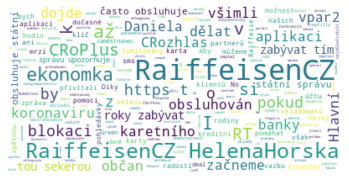

In [62]:


text = " ".join(fulltext for fulltext in rajf.my_pd.full_text)

stopwords = set(czech_stopwords)
stopwords.update(["s", "za", "se", "a", "to"])

# Generate a word cloud image
wordcloud_rajf = wordcloud.WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud_rajf, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
text = " ".join(review for review in df.description)

In [238]:
rajf.get_mentions()

In [241]:
rajf.mentions[1].__dict__

{'param_defaults': {'contributors': None,
  'coordinates': None,
  'created_at': None,
  'current_user_retweet': None,
  'favorite_count': None,
  'favorited': None,
  'full_text': None,
  'geo': None,
  'hashtags': None,
  'id': None,
  'id_str': None,
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_user_id': None,
  'lang': None,
  'location': None,
  'media': None,
  'place': None,
  'possibly_sensitive': None,
  'quoted_status': None,
  'quoted_status_id': None,
  'quoted_status_id_str': None,
  'retweet_count': None,
  'retweeted': None,
  'retweeted_status': None,
  'scopes': None,
  'source': None,
  'text': None,
  'truncated': None,
  'urls': None,
  'user': None,
  'user_mentions': None,
  'withheld_copyright': None,
  'withheld_in_countries': None,
  'withheld_scope': None},
 'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Jan 01 20:30:09 +0000 2021',
 'current_user_retweet': None,
 'favorite_count': 0,
 'favorited': False,


In [78]:
api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')

In [82]:
api.VerifyCredentials()

User(ID=237874317, ScreenName=Roman_Ruzica)

In [86]:
banks

{'Česká spořitelna': 'ceskasporitelna',
 'Československá obchodní banka': 'csob_cz',
 'Komerční Banka': 'komercka',
 'UniCredit': 'unicredit_czsk',
 'Raiffeisenbank': 'raiffeisencz'}

## Extract pandas functionality revisited

In [352]:
def add_prefix_to_dict(dictionary_to_change, prefix_to_add):
    init_dict_keys = list(dictionary_to_change.keys())
    changed_list = ["reply_" + s for s in init_dict_keys]
    final_dict = dict(zip(changed_list, list(dictionary_to_change.values())))
    return final_dict

In [ ]:
## Now extract timeline information for the user. If the timeline tweet is a reply to another tweet, also gather those tweets and gather information from them
#    def generate_mentions_pdf(self):
#        self.mentions_pd_list = []
#        for num, tweet in enumerate(self.mentions, start=0):
#            self.mentions_pd_list.append(pd.DataFrame( {**self.mentions[num].user_info, **self.mentions[num].tweet_info},
#                                                           index =  [self.mentions[num].user_info['screen_name']])
#                                   )
#            
#        self.mentions_pd = pd.concat(self.mentions_pd_list)
        
    def extract_timeline_tweet_data(self):
        for tl_tweet in self.timeline:
            tl_tweet.tweet_info ={k: tl_tweet._json[k] for k in self.interesting_tweet_attributes}
        

In [229]:
rajf

In [230]:
sporka

In [232]:
csob_cz

In [392]:

def extract_reply_tweet_info(self):
    self.reply_atributes_required = ( 'created_at', 'full_text', 'retweet_count', 'favorite_count')
    self.reply_user_required = ('screen_name', 'followers_count', 'friends_count', 'statuses_count', "favourites_count")
    for num in list(range(0, len(self.timeline))):


        try:
            self.timeline[num].reply_tweet_info = {k: self.timeline[num].reply_tweet._json[k] for k in self.reply_atributes_required}
        except:
            self.timeline[num].reply_tweet_info = {k: None for k in self.reply_atributes_required}

        try:
            self.timeline[num].user_info = {k: self.timeline[num].reply_tweet._json['user'][k] for k in self.reply_user_required}
        except: 
            self.timeline[num].user_info = {k: None for k in self.reply_user_required}

def generate_reply_pdf(self):
    self.reply_pd = []
    for num in list(range(0, len(self.timeline))):
            self.timeline[num].reply_info = {**self.timeline[num].user_info, **self.timeline[num].reply_tweet_info}
            
            self.timeline[num].reply_info = add_prefix_to_dict(self.timeline[num].reply_info, "reply_")
            
            self.timeline[num].concat_info = {**self.timeline[num].tweet_info, **self.timeline[num].reply_info}
            self.reply_pd.append(pd.DataFrame(self.timeline[num].concat_info,
                                                   index =  [num])
                            )
    self.timeline_pd = pd.concat(self.reply_pd)
        

In [ ]:
add_prefix_to_dict

In [387]:
komercka.timeline[3].tweet_info

{'full_text': '[#anketa] 💲 I když asi nikdo z nás nemá zbytečných 1,5 mld. dolarů, které bychom zainvestovali jako @elonmusk, jsou i jiné možnosti, jak vlastní úspory rozumně zhodnotit. Co je podle vás ideální investice?',
 'lang': 'cs',
 'retweet_count': 0,
 'created_at': 'Tue Feb 16 14:32:12 +0000 2021',
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>'}

In [ ]:
komercka.timeline[3].tweet_info

In [381]:
extract_reply_tweet_info(komercka)


In [393]:
generate_reply_pdf(komercka)

In [394]:
komercka.timeline_pd

,full_text,lang,retweet_count,created_at,source,reply_screen_name,reply_followers_count,reply_friends_count,reply_statuses_count,reply_favourites_count,reply_created_at,reply_full_text,reply_retweet_count,reply_favorite_count
0,"@stepanvacek @elonmusk @upvestcz Štěpáne,\n\nd...",cs,0,Tue Feb 16 15:47:30 +0000 2021,"<a href=""https://www.niceincontact.com"" rel=""n...",stepanvacek,41,95,253,794,Tue Feb 16 15:32:16 +0000 2021,@komercka @elonmusk Několik nápadů: 1) inv. do...,0,0
1,@BlanikZ 🙂🙏,und,0,Tue Feb 16 15:14:36 +0000 2021,"<a href=""https://www.niceincontact.com"" rel=""n...",None,None,None,None,None,None,None,None,None
2,"@stepanvacek @elonmusk Hezký den, Štěpáne,\n\n...",cs,0,Tue Feb 16 15:13:55 +0000 2021,"<a href=""https://www.niceincontact.com"" rel=""n...",None,None,None,None,None,None,None,None,None
3,[#anketa] 💲 I když asi nikdo z nás nemá zbyteč...,cs,0,Tue Feb 16 14:32:12 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",None,None,None,None,None,None,None,None,None
4,"@milacek_zen @milacek_zen\nDobrý den, \n\nvěřt...",cs,0,Tue Feb 16 12:53:41 +0000 2021,"<a href=""https://www.niceincontact.com"" rel=""n...",None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,"@Gui_01 Dobrý den, na některých pobočkách se n...",cs,0,Thu Feb 08 07:46:22 +0000 2018,"<a href=""http://engager.brandembassy.com/"" rel...",None,None,None,None,None,None,None,None,None
3221,"@Markito_Polo Good morning Markito, please sen...",en,0,Wed Feb 07 07:27:11 +0000 2018,"<a href=""http://engager.brandembassy.com/"" rel...",None,None,None,None,None,None,None,None,None
3222,"@dwbmb Dobrý den, máte pravdu, zaznamenali jsm...",cs,0,Tue Feb 06 13:43:08 +0000 2018,"<a href=""http://engager.brandembassy.com/"" rel...",None,None,None,None,None,None,None,None,None
3223,"@Jumanji1975cz Dobrý den, to nás moc těší :-)....",cs,0,Sat Feb 03 14:25:02 +0000 2018,"<a href=""http://engager.brandembassy.com/"" rel...",None,None,None,None,None,None,None,None,None


In [312]:
num = 1
sporka.timeline[num].reply_info


{'screen_name': 'MichalJarka4',
 'followers_count': 1,
 'friends_count': 184,
 'statuses_count': 91,
 'favourites_count': 844,
 'created_at': None,
 'full_text': None,
 'retweet_count': None,
 'favorite_count': None}

In [285]:
sporka.timeline[1].reply_tweet._json['user']['screen_name']

'MichalJarka4'

In [321]:
tweet_info = {k: sporka.timeline[num].reply_tweet._json[k] for k in sporka.reply_atributes_required}

In [323]:
sporka.timeline[1].tweet_info

{'created_at': 'Mon Feb 15 22:31:14 +0000 2021',
 'full_text': '@Ceskasporitelna George se fakt nepovedl. Máte každou chvilku výpadek něčeho. Mobilní bankovnictví nebo karty.... Je čas odejit.',
 'retweet_count': 0,
 'favorite_count': 0}

In [324]:
sporka.timeline[1].user_info

{'screen_name': 'MichalJarka4',
 'followers_count': 1,
 'friends_count': 184,
 'statuses_count': 91,
 'favourites_count': 844}

In [ ]:
user_info = {k: sporka.timeline[1].reply_tweet._json['user'][k] for k in sporka.reply_user_required}

In [309]:
user_info = {k: sporka.timeline[1].reply_tweet._json['user'][k] for k in sporka.reply_user_required}

In [310]:
user_info

{'screen_name': 'MichalJarka4',
 'followers_count': 1,
 'friends_count': 184,
 'statuses_count': 91,
 'favourites_count': 844}

In [261]:
sporka.timeline[1].reply_tweet._json

{'created_at': 'Mon Feb 15 22:31:14 +0000 2021',
 'id': 1361442977961361410,
 'id_str': '1361442977961361410',
 'full_text': '@Ceskasporitelna George se fakt nepovedl. Máte každou chvilku výpadek něčeho. Mobilní bankovnictví nebo karty.... Je čas odejit.',
 'truncated': False,
 'display_text_range': [17, 128],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'Ceskasporitelna',
    'name': 'Česká spořitelna',
    'id': 34302619,
    'id_str': '34302619',
    'indices': [0, 16]}],
  'urls': []},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': 1361249234511663107,
 'in_reply_to_status_id_str': '1361249234511663107',
 'in_reply_to_user_id': 34302619,
 'in_reply_to_user_id_str': '34302619',
 'in_reply_to_screen_name': 'Ceskasporitelna',
 'user': {'id': 1347999788348923907,
  'id_str': '1347999788348923907',
  'name': 'Michal Jarka',
  'screen_name': 'MichalJarka4',
  'location': ''

In [260]:
dir(sporka.timeline[1].reply_tweet._json)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [325]:
pd.concat(sporka.reply_pd)

,screen_name,followers_count,friends_count,statuses_count,favourites_count,created_at,full_text,retweet_count,favorite_count
0,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,Mon Feb 15 22:31:14 +0000 2021,@Ceskasporitelna George se fakt nepovedl. Máte...,0,0
2,None,None,None,None,None,Mon Feb 15 21:18:33 +0000 2021,@Ceskasporitelna George v telefonu nefunguje a...,0,0
3,None,None,None,None,None,Mon Feb 15 19:36:33 +0000 2021,@FilipHorky Díval jsem se na transparentní úče...,0,0
4,None,None,None,None,None,Mon Feb 15 17:19:03 +0000 2021,@Ceskasporitelna V prvnich minutach? Hlasilo t...,0,0
...,...,...,...,...,...,...,...,...,...
3243,None,None,None,None,None,None,None,None,None
3244,None,None,None,None,None,None,None,None,None
3245,None,None,None,None,None,None,None,None,None
3246,None,None,None,None,None,None,None,None,None


In [359]:
extract_replied_to_tweet_info(sporka)

In [360]:
extract_replied_to_tweet_info(sporka)
generate_reply_pdf(sporka)